In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import tqdm
from functools import lru_cache
import re
import networkx as nx
import scipy
import sklearn
import skimage

import xml.etree.ElementTree as et
from Bio.PDB import *
import nglview as nv


# http://nglviewer.org/nglview/latest/api.html
# https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
# https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_notebook/index.html
# https://amber-md.github.io/pytraj/latest/_api/pytraj.html

_ColormakerRegistry()

In [2]:
contact_matrix = np.loadtxt('/home/lillo/TesiCNTE/CNTE/dataset/contact_matrix.txt')   #laptop
#contact_matrix = np.loadtxt('/home/lillo/Code/Tesi/dataset/contact_matrix.txt')        #fisso
#contact_matrix_single = contact_matrix.reshape(100,100,12,12)

#gromacs_output = open('/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #fisso
#gromacs_output = open('/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #laptop

#path = '/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #fisso
path = '/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #laptop

# import 2mxu file (beta sheet)

#path_to_mmCIF = open('/home/lillo/TesiCNTE/pdb/2mxu/2mxu.cif')  ## laptop
path_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop
#pa_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop

#path_to_mmCIF = open('/home/lillo/Code/Tesi/pdb/2mxu/2mxu.cif')  ## fisso
#path_to_pdb = open('/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb')  ## fisso
#pa_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso

In [3]:
# open file .gro and return a list with one element per line of the .gro file
def read_gro(path):
    gromacs_output = open(path)

    gro_file = []
    for line in tqdm.tqdm(gromacs_output):
        gro_file.append(line)
        
        
            
    gromacs_output.close()        
    
    return gro_file
        


# return string in a string with numbers
def return_if_string(string):
    digits = []
    for i in string:
        if not i.isdigit():
            digits.append(i)
    
    string = ''.join(digits)
    
    return string


# return numbers in a string with numbers
def return_if_digit(string):
    digits = []
    for i in string:
        if i.isdigit():
            digits.append(i)
    
    string = ''.join(digits)
    
    return string


# remove first, second and last lines from gro_file and reorder information
def clean_gro_file(gro_file):
    cleaned_gro_file = []
    for aminoacid in tqdm.tqdm(gro_file[2:-1]):
        splitted = aminoacid.split()
        position_in_peptide = return_if_digit(splitted[0])
        residue = return_if_string(splitted[0])
        index = splitted[2]
        x = splitted[3]
        y = splitted[4]
        z = splitted[5]
        cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
    return cleaned_gro_file


# make a list of lists
# first list are the peptide
# nested list are the aminoacid info of the relative peptide
def get_peptides_coordinate(cleaned_gro_file, n_res):
    peptides_vector = []
    for peptides in tqdm.tqdm(range(int(len(cleaned_gro_file)/n_res))):
        peptides_vector.append([peptides])
        pep_index = peptides*n_res
        peptides_vector[peptides].extend(cleaned_gro_file[pep_index : pep_index+n_res])
        del peptides_vector[peptides][0]
    return peptides_vector



# retrive coordinate from the get_peptides_coordinate output
def get_coordinates(aminoacid):
    coordinates = [float(coordinate) for coordinate in aminoacid[3:]]
    return coordinates

# get dict of coordinate of aminoacids in 3d space
def get_coordinate_dict(peptide_info_list):

    coordinate_dict = {}
    for pep in range(len(peptide_info_list)):

        for aminoacid in peptide_info_list[pep]:
            residue = int(aminoacid[1])-1
            coordinates = get_coordinates(aminoacid)
            if pep in coordinate_dict:
                coordinate_dict[pep][residue] = coordinates
            if pep not in coordinate_dict:
                coordinate_dict[pep] = {residue:coordinates}
    return coordinate_dict


# get a dict with 3d coordinates for every aminoacid in the aggregate
def get_coordinate_dict_from_gro(cleaned_gro_file):

    aminoacid_coordinate_dict = {}

    for aminoacid in cleaned_gro_file:
        aminoacid_coordinate_dict[int(aminoacid[0])-1] = get_coordinates(aminoacid)
    
    return aminoacid_coordinate_dict



#compute euclidean distance
def get_euclidean_distance(point_1, point_2):
    
    euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

    return euclidean_distance


#create contact array for a contacting peptides couple
def get_contact_array(coordinate_dict, peptide_1, peptide_2):    
    
    contact_map = []
    for res in coordinate_dict[peptide_1]:
        first_amino = coordinate_dict[peptide_1][res]
        contact_map.append([res])

        for residue in coordinate_dict[peptide_2]:
            second_amino = coordinate_dict[peptide_2][residue]
            
            euclidean_distance = get_euclidean_distance(first_amino, second_amino)
            #euclidean_distance = np.sqrt(np.sum([((first_amino[0] - second_amino[0])**2), ((first_amino[1] - second_amino[1])**2), ((first_amino[2] - second_amino[2])**2)]))

            if 0.42 < euclidean_distance < 0.5:

                contact_map[res].append(1)

            else:
                contact_map[res].append(0)

        del contact_map[res][0]

        contact_array = np.asarray(contact_map)
    
    return contact_array
#### AGGIUNGI ARGOMENTO EUCLIDEAN_DISTANCE_RANGE DOPO ANALISI STATISTICA DELLE DISTANZE
#
#
#


#create contact array for every contacting peptide

def get_full_contact_array(coordinate_dict):
    full_map = []
    for peptide_uno in tqdm.tqdm(coordinate_dict):
        full_map.append([peptide_uno])
        for peptide_due in tqdm.tqdm(coordinate_dict):
            if peptide_uno != peptide_due:
                contact_array = get_contact_array(coordinate_dict, peptide_uno, peptide_due)
                full_map[peptide_uno].append(contact_array)

            else:
                zero_map = np.zeros((len(coordinate_dict[peptide_uno]), len(coordinate_dict[peptide_due])))

                full_map[peptide_uno].append(zero_map)

        del full_map[peptide_uno][0]

    full_array = np.asarray(full_map)
    
    return full_array



# compute distance between every aminoacid and all the others
def single_peptide_interaminoacid_distance(coordinate_dict, peptide):
    interaminoacid_distance = {}
    for key1 in coordinate_dict[peptide]:
        coordinates1 = coordinate_dict[peptide][key1]
        for key2 in coordinate_dict[peptide]:
            if key1 != key2:
                coordinates2 = coordinate_dict[peptide][key2]

                euclidean_distance = get_euclidean_distance(coordinates1,coordinates2)

                if key1 not in interaminoacid_distance:

                    interaminoacid_distance[key1] = {key2 : euclidean_distance}

                else:

                    interaminoacid_distance[key1][key2] = euclidean_distance
            else:
                pass
    
    return interaminoacid_distance


# create a matrix n_res*n_res where each element is the distance
# between the row aminoacid and the col aminoacid 
def get_interaminoacid_distance_array(interaminoacid_distance_dict):
    n_res = len(interaminoacid_distance_dict)
    distance_array = np.zeros((n_res, n_res))
    for aminoacid in interaminoacid_distance_dict:
        for second_aminoacid in interaminoacid_distance_dict[aminoacid]:
            distance_array[aminoacid, second_aminoacid] = interaminoacid_distance_dict[aminoacid][second_aminoacid]
    return distance_array



# calculate interaminoacid distance map
def get_interaminoacid_distance(coordinate_dict):
    dataset_distance_list = []
    for peptide in tqdm.tqdm(coordinate_dict):
        #dataset_distance_list.append([peptide])
        for aminoacid in coordinate_dict[peptide]:

            interaminoacid_distance = single_peptide_interaminoacid_distance(coordinate_dict, peptide)
            distance_array = get_interaminoacid_distance_array(interaminoacid_distance)

            dataset_distance_list.append(distance_array)
            #del dataset_distance_list[peptide][0]
            break
    
    dataset_distance_array = np.asarray(dataset_distance_list)
    
    return dataset_distance_array


# plt.imshow map
def show_distance_map(peptide):
    return plt.imshow(peptide)


# compute distance map between two peptides
def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

    distance_map = []
    for amino_1 in coordinate_dict[peptide_1]:
        coordinate_1 = coordinate_dict[peptide_1][amino_1]
        
        distance_map.append([amino_1])
        
        for amino_2 in coordinate_dict[peptide_2]:
            coordinate_2 = coordinate_dict[peptide_2][amino_2]
            
            euclidean_distance = get_euclidean_distance(coordinate_1, coordinate_2)
            distance_map[amino_1].append(euclidean_distance)
        
        del distance_map[amino_1][0]

    distance_map = np.asarray(distance_map)
    
    return distance_map



# compute aggregate distance map and return a 100x100x12x12 array
def compute_aggregate_distance_map(coordinate_dict):
    aggregate_distance_map = []

    for peptide_1 in tqdm.tqdm(coordinate_dict):
        aggregate_distance_map.append([peptide_1])
        for peptide_2 in tqdm.tqdm(coordinate_dict):
            distance_map = compute_distance_map(coordinate_dict, peptide_1, peptide_2)
            aggregate_distance_map[peptide_1].append(distance_map)

        del aggregate_distance_map[peptide_1][0]

    aggregate_distance_array = np.asarray(aggregate_distance_map)
    
    return aggregate_distance_array


# compute distance between each aminoacid and all the other and return a 1200x1200 array
def compute_for_aminoacid_distance(aminoacid_coordinate_dict):
    distance_list = []
    for aminoacid_1 in tqdm.tqdm(aminoacid_coordinate_dict):
        coordinate_1 = aminoacid_coordinate_dict[aminoacid_1]
        distance_list.append([aminoacid_1])
        for aminoacid_2 in tqdm.tqdm(aminoacid_coordinate_dict):
            coordinate_2 = aminoacid_coordinate_dict[aminoacid_2]
            euclidean_distance = get_euclidean_distance(coordinate_1, coordinate_2)
            distance_list[aminoacid_1].append(euclidean_distance)

        del distance_list[aminoacid_1][0]
    
    distance_array = np.asarray(distance_list)
    
    return distance_array


# compute
def compute_mask_distance_map(aggregate_contact_array, peptide_1, peptide_2):

    distance_map = aggregate_contact_array[peptide_1][peptide_2]
    distance_map_sum = np.sum(distance_map)
    distance_map_mean = np.mean(distance_map)
    distance_map_min = np.min(distance_map)
    distance_map_max = np.max(distance_map)
    distance_map_std = np.std(distance_map)
    distance_map_var = np.var(distance_map)

    distance_map_mask = np.zeros((distance_map.shape[0], distance_map.shape[1]))
    for row in range(distance_map.shape[0]):
        for col in range(distance_map.shape[1]):
            if distance_map[row][col] < (distance_map_mean - distance_map_std):
                distance_map_mask[row][col] = distance_map[row][col]
            else:
                pass
            
    return distance_map_mask



## get a list with [distance, row , col] for every element of a distance map
def get_distance_list_from_map(distance_map):
    distances = []
    for row in range(distance_map.shape[0]):
        for col in range(distance_map.shape[1]):
            distance = distance_map[row][col]
            if distance > 0:

                distances.append([distance, row, col])
    return distances


### DONT USE
#plot a peptide point cloud in 3d space. The box axis have arbitrary scale dependent on the aminoacids distance
def plot_peptide_point_cloud(coordinate_dict, peptide, centroid = False):
    x = []
    y = []
    z = []
    for residue in coordinate_dict[peptide]:
        point = coordinate_dict[peptide][residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])
        
    
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    if centroid == True:
        median_centroid = [np.median(x), np.median(y), np.median(z)]
    
    %matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
        
        ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
    
    return plt.show()


# DONT USE
# plot full dataset
# you can select to show the centroid
def plot_dataset_point_cloud(coordinate_dict, centroid = False):
    x = []
    y = []
    z = []
    for peptide in coordinate_dict:
        for aminoacid in coordinate_dict[peptide]:
        
            point = coordinate_dict[peptide][aminoacid]
            x.append(point[0])
            y.append(point[1])
            z.append(point[2])
        
    
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    if centroid == True:
        median_centroid = [np.median(x), np.median(y), np.median(z)]
    
    %matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
        
        ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
    
    return plt.show()



# DONT USE
#plot two peptide point cloud in 3d space. The box axis have arbitrary scale dependent on the aminoacids distance
# you can select to show the centroid
def plot_two_peptide_point_cloud(coordinate_dict, peptide_1, peptide_2, centroid = False):
    x_1 = []
    y_1 = []
    z_1 = []
    
    x_2 = []
    y_2 = []
    z_2 = []
    
    
    for residue_1 in coordinate_dict[peptide_1]:
        point_1 = coordinate_dict[peptide_1][residue_1]
        x_1.append(point_1[0])
        y_1.append(point_1[1])
        z_1.append(point_1[2])
        
    for residue_2 in coordinate_dict[peptide_2]:
        point_2 = coordinate_dict[peptide_2][residue_2]
        x_2.append(point_2[0])
        y_2.append(point_2[1])
        z_2.append(point_2[2])
        
    
    x_1 = np.asarray(x_1)
    y_1 = np.asarray(y_1)
    z_1 = np.asarray(z_1)
    
    x_2 = np.asarray(x_2)
    y_2 = np.asarray(y_2)
    z_2 = np.asarray(z_2)
    
    if centroid == True:
        median_centroid_1 = [np.median(x_1), np.median(y_1), np.median(z_1)]
        median_centroid_2 = [np.median(x_2), np.median(y_2), np.median(z_2)]
    
    %matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(x_1,y_1,z_1, c='b')
    ax.scatter3D(x_2,y_2,z_2, c='g')
    
    if centroid == True:
        
        ax.scatter3D(median_centroid_1[0], median_centroid_1[1], median_centroid_1[2], c='r')
        ax.scatter3D(median_centroid_2[0], median_centroid_2[1], median_centroid_2[2], c='r')

        
    
    return plt.show()


######## USE THIS

# plot a list of peptide point cloud in 3d space.
# The box axis have arbitrary scale dependent on the aminoacids distance
# you can select to show the centroid
def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
    x = []
    y = []
    z = []
    x_median = float
    y_median = float
    z_median = float
    

    for peptide in range(len(peptide_list)):
        x.append([peptide])
        y.append([peptide])
        z.append([peptide])
        for aminoacid in coordinate_dict[peptide_list[peptide]]:

            point = coordinate_dict[peptide_list[peptide]][aminoacid]
            x[peptide].append(point[0])
            y[peptide].append(point[1])
            z[peptide].append(point[2])

        del x[peptide][0]
        del y[peptide][0]
        del z[peptide][0]
        
    if centroid == True:
        
        def assemble_coordinate(axis_coordinate_list):
            median_list = []
            for coordinate_set in axis_coordinate_list:
                median = np.median(coordinate_set)
                median_list.append(median)
            return median_list
        
        x_median = assemble_coordinate(x)
        y_median = assemble_coordinate(y)
        z_median = assemble_coordinate(z)
        
        
                
        

    %matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')


    
    for pep in range(len(x)):
       
        ax.scatter3D(x[pep],y[pep],z[pep])
        
        if centroid == True:
            
            ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')
            
        
    return  fig, [x,y,z], [x_median, y_median, z_median]
            
# da completare con:
# peptidi diversi = colore diverso #FATTO
# centroide per ogni peptide #FATTO
# label per peptide
# label per aminoacido

# show contact maps of a peptide with connected peptide
def show_contacts(contact_dict, peptide):
    fig = plt.figure(figsize=(12,12))
    for e in range(len(contact_dict[peptide])):
        i = e
        keys = [key for key in contact_dict[peptide]]
        img = contact_dict[peptide][keys[e]]
        if len(contact_dict[peptide]) <= 1:
            fig.add_subplot(len(contact_dict[peptide]) , len(contact_dict[peptide]) , e+1)

        
        else:
            fig.add_subplot(len(contact_dict[peptide])/2 , len(contact_dict[peptide]) , e+1)
        plt.imshow(img)
        #show = plt.show()
    return plt.show()

#add label with key (second peptide)


#   crea libreria di matrici di shift

def shift_library_maker(row,col):
    ''' riceve numero di righe e di colonne
    restituisce un array shape((((row + col)*2)-2),row,col).
    ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''
    kron_list = []
    for e in tqdm.tqdm(range((-row+1), col)):
        array = np.eye(row, col, e)
        kron_list.append(array)
        kron_list.append(np.fliplr(array))
    kron_array = np.asarray(kron_list)
    
    return kron_array



def get_contact_maps(contact_matrix, n_res, n_pep):
    '''Reshape the big contact matrix in an easy to handle list, where:
    
    key:value correspond to:
    
    row peptide:list of peptide that makes contact with row peptide'''
    
    full_map = []
    for row in tqdm.tqdm(range(n_pep)):
        full_map.append([row])
        for col in range(n_pep):
            row_index = row * n_res
            col_index = col * n_res
            contact_map = contact_matrix[row_index:(row_index+n_res), col_index:(col_index+n_res)]
            #full_map[row].append([col,contact_map])  ## To use if you also want to get the col number for every map
            full_map[row].append(contact_map)
        del full_map[row][0]
    
    contact_array = np.asarray(full_map)
    
    return contact_array


def get_contact_map(contact_matrix, n_res, row, col):
    '''Get a single contact matrix from the full contact_maps.
    
    Arguments = contact_matrix, n_res=residue_number, row=index of the first peptide, col=index of the second peptide

    return = an np.array of shape (n_res*n_res)
    '''
    
    row_index = row * n_res
    col_index = col * n_res
    contact_map = contact_matrix[row_index:(row_index+n_res), col_index:(col_index+n_res)]
    #full_map[row].append([col,contact_map])  ## To use if you also want to get the col number for every map

    contact_map_array = np.asarray(contact_map)
    
    return contact_map



def normalized_cross_correlation_function(contact_map, shift_matrix_library):
    '''Calculate normalized cross correlation function between a contact map and an ideal map.
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
    
    
    cross_correlation_values = []
    max_val = []
    sum_contact_map = np.sum(contact_map)
    if sum_contact_map < 2:
        pass
    else:
        for z in range(shift_matrix_library.shape[0]):

            shift_matrix = shift_matrix_library[z]
            sum_shift_matrix = np.sum(shift_matrix)
            ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
            cross_correlation_values.append([ncc_value, z, sum_contact_map])
    
        max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)
    
    return max_val



# normalized cross correlation between all the dataset and the matrix library

def normalized_cross_correlation_for_dataset(contact_array, shift_matrix_library):
    '''Calculate normalized cross correlation function between the full contacts map and and the .
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
    
    contact_dict = {}
    for row in tqdm.tqdm(range(contact_array.shape[0])):
        for col in range((row+1),contact_array.shape[1]):
        #for col in range(contact_array.shape[1]):

            best_match = []
            best_match = normalized_cross_correlation_function(contact_array[row][col], shift_matrix_library)
            if len(best_match) == 0:
                pass
            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])
                else:
                    contact_dict[row] = [[row, col, best_match]]
    return contact_dict



# Serve a creare vettori contenenti peptidi e relative compatibilità
#
# Crea dict con key:value dati da indice_peptide:list_con_cui_ci_sono_contatti
# Serve per formare il grafo da esplorare


def get_contact_index(contact_dict):    
    contact_index = {}
    for first_peptide in tqdm.tqdm(contact_dict):
        for second_peptide in contact_dict[first_peptide]:
            if first_peptide in contact_index:
                contact_index[first_peptide].append(second_peptide)
            else:
                contact_index[first_peptide] = [second_peptide]
    return contact_index


# Crea dict con key:value dati da indice_peptide:set_con_cui_ci_sono_contatti
# Set serve per rimuovere elementi gia usati

def get_contact_index_set(contact_dict):    
    contact_index_set = {}
    for first_peptide in tqdm.tqdm(contact_dict):
        for second_peptide in contact_dict[first_peptide]:
            if first_peptide in contact_index_set:
                contact_index_set[first_peptide].add(second_peptide)
            else:
                contact_index_set[first_peptide] = {second_peptide}
    return contact_index_set




# take array, return vector with sum along columns
def get_row_vector(array):
    row_vector = np.sum(array, axis=0)
    return row_vector

# take array, return vector with sum along row
def get_col_vector(array):
    col_vector = np.sum(array, axis=1)
    return col_vector


#denoise dataset
def denoise_full_dataset(contact_maps, cross_corre1ation_results, shift_matrix_library):
    
    '''Denoise the contact_maps dataset using the shift_matrix
    
    Arguments : contact_maps, cross_correlation_result, shift_matrix_library
    
    return : a dict with key:value = row : row, col, denoised_map
    
    '''
    
    denoised_dict = {}
    for peptides in tqdm.tqdm(cross_corre1ation_results):
        for contacts in cross_corre1ation_results[peptides]:
            row = contacts[0]
            col = contacts[1]
            contact_map = contact_maps[row][col]
            shift_matrix = shift_matrix_library[contacts[2][1]]
            denoised_map = contact_map * shift_matrix

            if row in denoised_dict:
                denoised_dict[row].append([row, col, denoised_map])
            else:
                denoised_dict[row] = [[row, col, denoised_map]]
    
    return denoised_dict    
    
    

#create a dict that contains the peptide couples contact and the specular peptide couples contact
def reconstruct_full_matrix(partial_contact_matrix):
    full_denoised_dict = {}
    for contacts in tqdm.tqdm(denoised_dict):
        for pep_couple in denoised_dict[contacts]:
            first_pep = pep_couple[0]
            second_pep = pep_couple[1]
            contact_map = pep_couple[2]

            if first_pep in full_denoised_dict:
                full_denoised_dict[first_pep][second_pep] = contact_map

            if first_pep not in full_denoised_dict:
                full_denoised_dict[first_pep] = {second_pep:contact_map}

            if second_pep in full_denoised_dict:
                full_denoised_dict[second_pep][first_pep] = contact_map.T

            if second_pep not in full_denoised_dict:
                full_denoised_dict[second_pep] = {first_pep:contact_map.T}
    return full_denoised_dict


# insert peptide, shows its contact map
# Da perfezionare
def show_contacts(contact_dict, peptide):
    fig = plt.figure(figsize=(5,5))
    for e in range(len(contact_dict[peptide])):
        keys = [key for key in contact_dict[peptide]]
        img = contact_dict[peptide][keys[e]]
        print(keys[e])

        if len(contact_dict[peptide]) <= 1:
            fig.add_subplot(len(contact_dict[peptide]) , len(contact_dict[peptide]) , e+1)
            
        if (len(contact_dict[peptide])%2) == 0:
            #print(len(contact_dict[peptide]))
            fig.add_subplot(len(contact_dict[peptide])/2 , len(contact_dict[peptide])/2, e+1)

        else:
            #fig.add_subplot((len(contact_dict[peptide])/2)+1 , len(contact_dict[peptide])/2, e+1)
            fig.add_subplot(len(contact_dict[peptide])/2 , len(contact_dict[peptide]), e+1)

        plt.imshow(img)
        
    return plt.show()

#add label with key (second peptide)


# graph clustering
def nx_graph_search(full_denoised_dict, contact_index):
    
    graph = nx.MultiGraph()
    
    for peptide_1 in full_denoised_dict:
        for peptide_2 in full_denoised_dict[peptide_1]:
            array_1 = full_denoised_dict[peptide_1][peptide_2]
            for peptide_3 in full_denoised_dict[peptide_2]:
                if peptide_3 != peptide_1:
                    array_2 = full_denoised_dict[peptide_2][peptide_3]

                    vect_1 = get_row_vector(array_1)
                    vect_2 = get_col_vector(array_2)

                    contacts = np.dot(vect_1, vect_2)
                    
                    if contacts >= 3:
                        
                        #print('peptide_1 is:', peptide_1)
                        #print('peptide_2 is:', peptide_2)
                        #print('peptide_3 is:', peptide_3)
                        #print('contacts is:', contacts)
                        
                        #graph.add_path([peptide_1, peptide_2, peptide_3])

                        graph.add_edge(peptide_1, peptide_2)
                     
                        graph.add_edge(peptide_2, peptide_3)

                        #print(graph[0])

    return graph

#A novel graph clustering algorithm based on discrete-time quantum random walk
#S.G. Roya, A. Chakrabarti


# working with networkX
# if contacts >= target

# when you add_edge, nodes are created if they are not there
# you can put info in edge (as distance, n of contacts, contact map)
# you HAVE TO (but you can not also) put key to index multiple nodes that are joined with a single node
# 
# add edge from pep1 to pep2 (you HAVE TO (###to explore utility of key) put key to index multiple nodes that are joined with a single node)
# add edge from pep3 to pep3 ( same as before with key)



#############################################################
#####################################################
#############################################################
#####################################################
#############################################################

# Pdb analysis

# parse pdb e create structure
def get_structure_from_pdb(path_to_pdb):
    
    file = open(path_to_pdb)
    
    parser = PDBParser()
    
    structure = parser.get_structure('beta_sheet', file)
    
    file.close()

    return structure


# create dictionary from pdb
# with coordinate for chain as three vectors (x,y,z) containing respective points coordinate
# the dict is structured as:
# 
def get_ca_coordinate_from_structure(structure):

    coordinate_dict = {}

    for model in structure.get_list():
        model_id = int(str(model).split('=')[1][0])

        for chain in model.get_list():
            chain_id = str(chain).split('=')[1][0]

            if model_id not in coordinate_dict:
                coordinate_dict[model_id] = {chain_id:[]}

            else:
                coordinate_dict[model_id][chain_id] = []
            
            x = []
            y = []
            z = []

            for residue_index, residue in enumerate(chain.get_list()):
                #residue_id = str(residue).split()[1]
                
                x.append(float(str(residue['CA'].get_vector()).split()[1][:-1]))
                y.append(float(str(residue['CA'].get_vector()).split()[2][:-1]))
                z.append(float(str(residue['CA'].get_vector()).split()[3][:-1]) )
                
            coordinate_dict[model_id][chain_id].append(x)
            coordinate_dict[model_id][chain_id].append(y)
            coordinate_dict[model_id][chain_id].append(z)

    return coordinate_dict


# create dictionary from pdb
# with coordinate as single vector per point
def get_ca_coordinate_from_structure_as_vector(structure):

    coordinate_dict = {}

    for model in structure.get_list():
        model_id = int(str(model).split('=')[1][0])

        for chain in model.get_list():
            chain_id = str(chain).split('=')[1][0]

            if model_id not in coordinate_dict:
                coordinate_dict[model_id] = {chain_id:{}}

            else:
                coordinate_dict[model_id][chain_id] = {}

            for residue_index, residue in enumerate(chain.get_list()):
                residue_id = str(residue).split()[1]

                x = float(str(residue['CA'].get_vector()).split()[1][:-1])
                y = float(str(residue['CA'].get_vector()).split()[2][:-1])
                z = float(str(residue['CA'].get_vector()).split()[3][:-1])            

                coordinate_dict[model_id][chain_id][residue_index] = [x,y,z] # no residue, just coordinate vector

    return coordinate_dict


# get distance dict for every aminoacid of the selected models

def get_distances_dict_from_structure_vectors(structure_vectors, models = []):
    
    distance_dict = {}
    
    for model in models:

        for chain_1 in structure_vectors[model]:

            distance_dict[chain_1] = {}

            for chain_2 in structure_vectors[model]:

                distance_dict[chain_1][chain_2] = {}


                for residue_1 in structure_vectors[model][chain_1]:

                    point_1 = structure_vectors[model][chain_1][residue_1]

                    distance_dict[chain_1][chain_2][residue_1] = {}


                    for residue_2 in structure_vectors[model][chain_2]:

                        point_2 = structure_vectors[model][chain_2][residue_2]

                        distance = get_euclidean_distance(point_1,point_2)

                        distance_dict[chain_1][chain_2][residue_1][residue_2] = distance

    return distance_dict


# compute distance map array to visualize image and calculate mask
def compute_distance_maps(distance_dict):

    distance_maps_list = []
    #distance_map = np.zeros((32,32)) # come farà l'utente a saperlo?

    for chain_1_index, chain_1 in enumerate(distance_dict):
        distance_maps_list.append([chain_1_index])
        for chain_2_index, chain_2 in enumerate(distance_dict[chain_1]):
            distance_map = np.zeros((len(distance_dict[chain_1][chain_2]), len(distance_dict[chain_1][chain_2][0]))) # come farà l'utente a saperlo?

            for residue_1 in distance_dict[chain_1][chain_2]:
                for residue_2 in distance_dict[chain_1][chain_2][residue_1]:
                    distance_map[residue_1][residue_2] = distance_dict[chain_1][chain_2][residue_1][residue_2]


            distance_maps_list[chain_1_index].append(distance_map)
        del distance_maps_list[chain_1_index][0]

    distance_maps_array = np.asarray(distance_maps_list)
    return distance_maps_array




# compute contact map from distance array
# trying to differentiate between angstrom and nanometers

def compute_contact_maps_dict(distance_maps_array):
    
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1]

    contact_map_dict = {}

    if intrapeptide_minimum_distance < 1:
        threshold_distance = (intrapeptide_minimum_distance + 0.12)

    else:
        threshold_distance = (intrapeptide_minimum_distance + 1.2)


    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_dict[model_1] = {}
        for model_2 in range(distance_maps_array[model_1].shape[0]):
            
            if model_1 == model_2:
                
                contact_map_dict[model_1][model_2] = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))
                
                
            else:
                
            
                
                contact_map_dict[model_1][model_2] = {}

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = distance
                        else:
                            pass



                contact_map_dict[model_1][model_2] = contact_map
            
    return contact_map_dict



def compute_contact_maps_as_array(distance_maps_array):
    
    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance uo to 137% of the intrapeptide_minimum_distance
    threshold_distance = (intrapeptide_minimum_distance * 1.37)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True label
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)
    
    contact_array = np.asarray(contact_map_list)
            
    return contact_array



                



In [4]:
n_res = 12

1203it [00:00, 946669.36it/s]
100%|██████████| 1200/1200 [00:00<00:00, 97938.64it/s]

100%|██████████| 1200/1200 [00:00<00:00, 60390.25it/s]

100%|██████████| 1200/1200 [00:00<00:00, 64652.08it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95408.21it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92086.37it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94104.23it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96289.81it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92734.50it/s]

100%|██████████| 1200/1200 [00:00<00:00, 99000.09it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96091.27it/s]

100%|██████████| 1200/1200 [00:00<00:00, 90175.85it/s]

100%|██████████| 1200/1200 [00:00<00:00, 100166.47it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92472.12it/s]

100%|██████████| 1200/1200 [00:00<00:00, 90779.25it/s]

100%|██████████| 1200/1200 [00:00<00:00, 100703.58it/s]

100%|██████████| 1200/1200 [00:00<00:00, 100284.22it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89416.49it/s]

100%|██████████

100%|██████████| 1200/1200 [00:00<00:00, 99771.34it/s]

100%|██████████| 1200/1200 [00:00<00:00, 83492.27it/s]

100%|██████████| 1200/1200 [00:00<00:00, 39609.08it/s]

100%|██████████| 1200/1200 [00:00<00:00, 52047.66it/s]

100%|██████████| 1200/1200 [00:00<00:00, 84358.49it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95734.87it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92329.62it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89837.84it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95515.04it/s]

100%|██████████| 1200/1200 [00:00<00:00, 83239.59it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95972.18it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92613.34it/s]

100%|██████████| 1200/1200 [00:00<00:00, 84317.50it/s]

100%|██████████| 1200/1200 [00:00<00:00, 91215.22it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92785.78it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94243.43it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89261.09it/s]

100%|██████████| 1200/1200 [00:00<00:00, 90694.1

100%|██████████| 1200/1200 [00:00<00:00, 88596.46it/s]

100%|██████████| 1200/1200 [00:00<00:00, 98013.02it/s]

100%|██████████| 1200/1200 [00:00<00:00, 79329.90it/s]

100%|██████████| 1200/1200 [00:00<00:00, 75568.51it/s]

100%|██████████| 1200/1200 [00:00<00:00, 65052.34it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95622.10it/s]

100%|██████████| 1200/1200 [00:00<00:00, 84797.65it/s]

100%|██████████| 1200/1200 [00:00<00:00, 98403.94it/s]

100%|██████████| 1200/1200 [00:00<00:00, 97955.80it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95974.01it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96704.23it/s]

100%|██████████| 1200/1200 [00:00<00:00, 87343.42it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94979.71it/s]

100%|██████████| 1200/1200 [00:00<00:00, 86352.89it/s]

100%|██████████| 1200/1200 [00:00<00:00, 84352.83it/s]

100%|██████████| 1200/1200 [00:00<00:00, 81809.48it/s]

100%|██████████| 1200/1200 [00:00<00:00, 80328.85it/s]

100%|██████████| 1200/1200 [00:00<00:00, 82514.9

100%|██████████| 1200/1200 [00:00<00:00, 95665.72it/s]

100%|██████████| 1200/1200 [00:00<00:00, 88951.89it/s]

100%|██████████| 1200/1200 [00:00<00:00, 68428.16it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92101.54it/s]

100%|██████████| 1200/1200 [00:00<00:00, 78505.81it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89243.68it/s]

100%|██████████| 1200/1200 [00:00<00:00, 95372.05it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96172.06it/s]

100%|██████████| 1200/1200 [00:00<00:00, 86123.87it/s]

100%|██████████| 1200/1200 [00:00<00:00, 58531.30it/s]

100%|██████████| 1200/1200 [00:00<00:00, 60781.88it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93160.18it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96628.11it/s]

100%|██████████| 1200/1200 [00:00<00:00, 53303.87it/s]

100%|██████████| 1200/1200 [00:00<00:00, 78050.50it/s]

100%|██████████| 1200/1200 [00:00<00:00, 88049.35it/s]

100%|██████████| 1200/1200 [00:00<00:00, 91844.40it/s]

100%|██████████| 1200/1200 [00:00<00:00, 77932.0

100%|██████████| 1200/1200 [00:00<00:00, 57754.22it/s]

100%|██████████| 1200/1200 [00:00<00:00, 71513.12it/s]

100%|██████████| 1200/1200 [00:00<00:00, 85913.64it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92782.36it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93268.93it/s]

100%|██████████| 1200/1200 [00:00<00:00, 81045.44it/s]

100%|██████████| 1200/1200 [00:00<00:00, 64608.93it/s]

100%|██████████| 1200/1200 [00:00<00:00, 78867.48it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93851.55it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92468.72it/s]

100%|██████████| 1200/1200 [00:00<00:00, 88347.64it/s]

100%|██████████| 1200/1200 [00:00<00:00, 81937.34it/s]

100%|██████████| 1200/1200 [00:00<00:00, 78220.32it/s]

100%|██████████| 1200/1200 [00:00<00:00, 87402.58it/s]

100%|██████████| 1200/1200 [00:00<00:00, 91231.76it/s]

100%|██████████| 1200/1200 [00:00<00:00, 90641.92it/s]

100%|██████████| 1200/1200 [00:00<00:00, 82077.64it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89585.1

100%|██████████| 1200/1200 [00:00<00:00, 92054.37it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93039.63it/s]

100%|██████████| 1200/1200 [00:00<00:00, 86233.06it/s]

100%|██████████| 1200/1200 [00:00<00:00, 87760.72it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94654.62it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93797.33it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89884.36it/s]

100%|██████████| 1200/1200 [00:00<00:00, 82627.39it/s]

100%|██████████| 1200/1200 [00:00<00:00, 91578.69it/s]

100%|██████████| 1200/1200 [00:00<00:00, 81938.67it/s]

100%|██████████| 1200/1200 [00:00<00:00, 89326.04it/s]

100%|██████████| 1200/1200 [00:00<00:00, 92163.94it/s]

100%|██████████| 1200/1200 [00:00<00:00, 91804.19it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93103.31it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94491.14it/s]

100%|██████████| 1200/1200 [00:00<00:00, 81249.53it/s]

100%|██████████| 1200/1200 [00:00<00:00, 73278.95it/s]

100%|██████████| 1200/1200 [00:00<00:00, 72929.6

100%|██████████| 1200/1200 [00:00<00:00, 72922.22it/s]

100%|██████████| 1200/1200 [00:00<00:00, 88350.74it/s]

100%|██████████| 1200/1200 [00:00<00:00, 83958.84it/s]

100%|██████████| 1200/1200 [00:00<00:00, 96060.10it/s]

100%|██████████| 1200/1200 [00:00<00:00, 93201.58it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94619.03it/s]

100%|██████████| 1200/1200 [00:00<00:00, 97988.22it/s]

100%|██████████| 1200/1200 [00:00<00:00, 100204.36it/s]

100%|██████████| 1200/1200 [00:00<00:00, 83238.21it/s]

100%|██████████| 1200/1200 [00:00<00:00, 97644.14it/s]

100%|██████████| 1200/1200 [00:00<00:00, 94763.33it/s]

100%|██████████| 100/100 [00:00<00:00, 387285.69it/s]


29
34
47
91


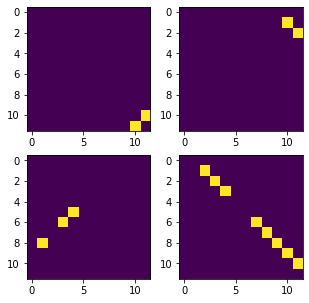

In [5]:
gro_file = read_gro(path)

cleaned_gro_file = clean_gro_file(gro_file)

peptide_info_list = get_peptides_coordinate(cleaned_gro_file, n_res)

coordinate_dict = get_coordinate_dict(peptide_info_list)

#contact_array = get_full_contact_array(coordinate_dict)

interaminoacid_distance_dataset = get_interaminoacid_distance(coordinate_dict)

aggregate_distance_array = compute_aggregate_distance_map(coordinate_dict)

aminoacid_coordinate_dict = get_coordinate_dict_from_gro(cleaned_gro_file)

distance_array = compute_for_aminoacid_distance(aminoacid_coordinate_dict) 


#######################################################
######################################################
#######################################################
######################################################
#######################################################

n_res = 12
n_pep = 100

#create shift matrix library
shift_matrix_library = shift_library_maker(n_res,n_res)

#reshape the original input, corresponding to a matrix of shape 1200*1200
#in an array of shape 100,100,12,12.
#the row,col index of the 100*100 matrix are the 100 peptide monomers 
#every element of the 100*100 matrix is an array of shape 12*12
#corresponding to the contact map
#the row,col index are the aminoacids of the peptide
#
#return an array of shape=(number of peptide, number of peptide) in which every element
#is an array of shape=(number of peptide's aminoacidic residues, (number of peptide's aminoacidic residues)
#that is the contact map of two peptides of the simulation
contact_maps = get_contact_maps(contact_matrix, n_pep=n_pep, n_res=n_res)

# compute the normalized cross correlation
cross_corre1ation_results = normalized_cross_correlation_for_dataset(contact_maps, shift_matrix_library)

#denoise dataset
denoised_dict = denoise_full_dataset(contact_maps=contact_maps, cross_corre1ation_results=cross_corre1ation_results, shift_matrix_library=shift_matrix_library)

#reconstruct a dict with the couples and specular couples contact map
full_denoised_dict = reconstruct_full_matrix(denoised_dict)

# dict of contacting peptides
contact_index = get_contact_index(full_denoised_dict)

# set of contacting peptides
# contact_index_set = get_contact_index_set(full_denoised_dict)

# show contacts map of a peptide
show_contacts(full_denoised_dict, 0)

# construct graph
graph = nx_graph_search(full_denoised_dict, contact_index)

############ Parsing .pdb

# get structure from .pdb
# parsed with BioPython PDBParser
structure = get_structure_from_pdb(path_to_pdb)

# get dictionary from structure
structure_dict = get_ca_coordinate_from_structure(structure)

# get dictionary from structure with coordinate as vector
structure_vectors = get_ca_coordinate_from_structure_as_vector(structure)

# get dictionary with distances between aminoacids in the same structure
# you can select the models from which to calculate distances 
distance_dict = get_distances_dict_from_structure_vectors(structure_vectors, [0])

# compute distance maps from distancedict
distance_maps_array = compute_distance_maps(distance_dict)

# compute contact map from distance maps in a dict
contact_map_dict = compute_contact_maps_dict(distance_maps_array)

# compute contact map from distance map in array
contact_map_array = compute_contact_maps_as_array(distance_maps_array)






In [ ]:
# WORKING
#
# Output a full distance array of shape 1200x1200 
#

fig = plt.figure(figsize=(20,20))
#for i in range(10):
img = distance_array # change to move the slicing window
fig.add_subplot(1, 1 , 1)
plt.imshow(img)

plt.show()
#plt.close()

In [ ]:
plt.imshow(aggregate_distance_array[0][91])

In [ ]:
plt.imshow(aggregate_distance_array[51][73])

In [ ]:
plt.imshow(interaminoacid_distance_dataset[0])

In [ ]:
plt.imshow(interaminoacid_distance_dataset[9])

In [ ]:
# PLOT AGGREGATE

aggregate = plot_peptide_list(coordinate_dict, peptide_list = [e for e in range(100)], centroid = False)

In [ ]:
nx.draw_networkx(graph)

In [ ]:
plt.close()

In [ ]:
%matplotlib notebook

In [ ]:
#beta_sheet

In [ ]:
contact_map_dict[0][0]

In [ ]:
%matplotlib notebook

In [ ]:
#WORKING
#
# output a set of 10 intrapeptide distance map from interaminoacid distance dataset
#


fig = plt.figure(figsize=(10,10))
for i in range(10):
    img = interaminoacid_distance_dataset[i+50] # change to move the slicing window
    fig.add_subplot(5, 2 , i+1)
    plt.imshow(img)

plt.show()
#plt.close()

In [ ]:
plt.close()

In [ ]:
for model in structure.get_list():
    for chain in model.get_list():
        for residue in chain.get_list():
            for atom in residue.get_list():
                print(atom.get_vector())

In [ ]:
a = structure_dict[0]['A']

In [ ]:
b = structure_dict[0]['B']

In [ ]:
plt.imshow(distance_map)

In [ ]:
get_distance_list_from_map(distance_map)

In [ ]:
plt.close()

In [ ]:
%matplotlib notebook

In [ ]:
#def plot_structure(structure_dict,):
fig = plt.figure()
ax = plt.axes(projection='3d')

#for model in structure_dict:
#for chain in structure_dict[0]:
ax.scatter3D(structure_dict[0]['A'][0],structure_dict[0]['A'][1],structure_dict[0]['A'][2])
ax.scatter3D(structure_dict[0]['B'][0],structure_dict[0]['B'][1],structure_dict[0]['B'][2])
#x.scatter3D(structure_dict[1]['E'][0],structure_dict[1]['E'][1],structure_dict[1]['E'][2])


    
plt.show()

In [ ]:
def plot_from_structure_vectors(structure_dict, models=[], chains=[], ca=[]):

    if chains == []:
        chains = [chain for chain in structure_dict[models[0]]]
        
    if ca == []:
        ca = range(len(structure_dict[models[0]][chains[0]][0]))
        
    fig = plt.figure()
    ax = plt.axes(projection='3d') 
    
    
    
    for model in models:
        
        for chain in chains: 
            
            x = structure_dict[model][chain][0]
            y = structure_dict[model][chain][1]
            z = structure_dict[model][chain][2]
        
            ax.scatter3D(x,y,z)
    
    
    
    return plt.show()


#aggiungere modo per selezionare ca
            
        
        

In [ ]:
plot_from_structure_dict(structure_dict, models=[0,1,2], chains=['A','B','C','D'])

In [ ]:
a = structure_dict[0]['A']
b = structure_dict[0]['B']

distance_map = np.zeros((len(a[0]), len(b[0])))


for ca_1 in range(len(a[0])):
    #print(ca_1)
    
    for ca_2 in range(len(b[0])):
        
        point_1 = [a[0][ca_1], a[1][ca_1], a[2][ca_1]]
        point_2 = [b[0][ca_2], b[1][ca_2], b[2][ca_2]]
        #print(point_1, point_2)
    #    point_2 = b[residue_2]
        distance = get_euclidean_distance(point_1,point_2)
        
        distance_map[ca_1][ca_2] = distance
        
        
        
        
plt.imshow(distance_map)

In [ ]:
for row in range(distance_map.shape[0]):
    for col in range(distance_map.shape[1]):
        distance = distance_map[row][col]
        if distance > 5:
            distance_map[row][col] = 0

In [ ]:
plt.imshow(distance_map)

In [ ]:
plt.close()

In [ ]:
structure_coordinate_vectors

In [ ]:
# create dictionary from pdb
def get_ca_coordinate_from_structure_as_vector(structure):

    coordinate_dict = {}

    for model in structure.get_list():
        model_id = int(str(model).split('=')[1][0])

        for chain in model.get_list():
            chain_id = str(chain).split('=')[1][0]

            if model_id not in coordinate_dict:
                coordinate_dict[model_id] = {chain_id:{}}

            else:
                coordinate_dict[model_id][chain_id] = {}

            for residue_index, residue in enumerate(chain.get_list()):
                residue_id = str(residue).split()[1]

                x = float(str(residue['CA'].get_vector()).split()[1][:-1])
                y = float(str(residue['CA'].get_vector()).split()[2][:-1])
                z = float(str(residue['CA'].get_vector()).split()[3][:-1])            

                #coordinate_dict[model_id][chain_id][residue_index] = [residue_id,[x,y,z]] # give residue name

                coordinate_dict[model_id][chain_id][residue_index] = [x,y,z] # no residue, just coordinate vector

    return coordinate_dict

In [ ]:
structure_vectors[0]

In [ ]:
# get distance dict for every aminoacid of the selected models

def get_distances_dict_from_structure_vectors(structure_vectors, models = []):
    
    distance_dict = {}
    
    for model in models:

        for chain_1 in structure_vectors[model]:

            distance_dict[chain_1] = {}

            for chain_2 in structure_vectors[model]:

                distance_dict[chain_1][chain_2] = {}


                for residue_1 in structure_vectors[model][chain_1]:

                    point_1 = structure_vectors[model][chain_1][residue_1]

                    distance_dict[chain_1][chain_2][residue_1] = {}


                    for residue_2 in structure_vectors[model][chain_2]:

                        point_2 = structure_vectors[model][chain_2][residue_2]

                        distance = get_euclidean_distance(point_1,point_2)

                        distance_dict[chain_1][chain_2][residue_1][residue_2] = distance

    return distance_dict
            

In [ ]:
first = structure_coordinate_vectors[0]['A'][0]

In [ ]:
last = structure_coordinate_vectors[0]['A'][31]

In [ ]:
distance_map_list

In [ ]:
get_euclidean_distance(first, last)

In [ ]:
print([e for e in range(25)])

In [ ]:
distance_dict = get_distances_dict_from_structure_vectors(structure_vectors, [0])

In [ ]:
len(distance_dict['A']['A'])

In [ ]:
def compute_distance_maps(distance_dict):

    distance_maps_list = []
    #distance_map = np.zeros((32,32)) # come farà l'utente a saperlo?

    for chain_1_index, chain_1 in enumerate(distance_dict):
        distance_maps_list.append([chain_1_index])
        for chain_2_index, chain_2 in enumerate(distance_dict[chain_1]):
            distance_map = np.zeros((len(distance_dict[chain_1][chain_2]), len(distance_dict[chain_1][chain_2][0]))) # come farà l'utente a saperlo?

            for residue_1 in distance_dict[chain_1][chain_2]:
                for residue_2 in distance_dict[chain_1][chain_2][residue_1]:
                    distance_map[residue_1][residue_2] = distance_dict[chain_1][chain_2][residue_1][residue_2]


            distance_maps_list[chain_1_index].append(distance_map)
        del distance_maps_list[chain_1_index][0]

    distance_maps_array = np.asarray(distance_maps_list)
    return distance_maps_array
                

In [ ]:
distance_maps_array = compute_distance_maps(distance_dict)

In [ ]:
distance_maps_list[0][0]

In [ ]:
plt.imshow(distance_maps_array[0][1])

In [ ]:
plt.imshow(distance_maps_array[0][0])

In [ ]:
map_distance = get_distance_list_from_map(distance_maps_array[0][1])

In [ ]:
plt.imshow(distance_maps_array[0][1])

In [ ]:
a = distance_maps_array[0][1]

In [ ]:
b = skimage.filters.gaussian(a)

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(b)

In [ ]:
a_mask = compute_mask_distance_map(distance_maps_array, 0, 1)

In [ ]:
plt.imshow(a_mask)

In [ ]:
distance_map = np.zeros((distance_maps_array[0][1].shape[0], distance_maps_array[0][1].shape[1]))
for row in range(distance_maps_array[0][1].shape[0]):
    for col in range(distance_maps_array[0][1].shape[1]):
        distance = distance_maps_array[0][1][row][col]
        if distance > 5:
            distance_map[row][col] = 0

In [ ]:
plt.imshow(distance_maps_array[0][0])

In [ ]:
distance_maps_array.shape

In [ ]:
intrapeptide_minimum_distance = distance_maps_array[0][0][0][1]

In [ ]:
# compute contact map from distance array

def compute_contact_maps(distance_maps_array):
    
    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_dict = {}
    contact_map_list = []
    
    # contact is in a distance uo to 131% of the intrapeptide_minimum_distance
    threshold_distance = (intrapeptide_minimum_distance * 1.31)

    for model_1 in range(distance_maps_array.shape[0]):
        #contact_map_dict[model_1] = {}
        contact_map_list.append([model_1])
        for model_2 in range(distance_maps_array[model_1].shape[0]):
            
            if model_1 == model_2:
                
                contact_map_dict[model_1][model_2] = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))
                
                
            else:
                
            
                
                contact_map_dict[model_1][model_2] = {}

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = distance
                        else:
                            pass



                contact_map_dict[model_1][model_2] = contact_map
            
    return contact_map_dict




In [ ]:
contact_map_dict = compute_contact_maps(distance_maps_array)

In [ ]:
plt.imshow(contact_map_dict[10][11])

In [ ]:
a = compute_aggregate_distance_map

In [ ]:
a = distance_maps_array[0][0][0][1]

In [ ]:
1.2/a

In [ ]:
a * 1.31

In [ ]:
a + 1.2

In [ ]:
contact_maps[0][0]

In [ ]:
a = list(contact_map_dict)

In [ ]:
a

In [ ]:
def compute_contact_maps_as_array(distance_maps_array):
    
    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance uo to 131% of the intrapeptide_minimum_distance
    threshold_distance = (intrapeptide_minimum_distance * 1.37)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)
    
    contact_array = np.asarray(contact_map_list)
            
    return contact_array


In [ ]:
len(contact_map_list[1][1][0])

In [ ]:
contact_map_list[0][0][0]

In [ ]:
plt.imshow(contact_array[6][5])

In [ ]:
contact_array = compute_contact_maps_as_array(distance_maps_array)

In [ ]:
coordinate_dict

In [ ]:
aggregate_distance_array[0][0][0]

In [ ]:
contact_array_aggregate = compute_contact_maps_as_array(aggregate_distance_array)

In [ ]:
np.sum(contact_array_aggregate)

In [ ]:
contact_array_aggregate[0][91]

In [ ]:
plt.imshow(contact_map_array[5][6])

In [ ]:
plt.imshow(contact_map_array[6][7])

In [ ]:
distance_maps_array[6][7]

In [ ]:
distance_maps_array[5][6]

In [ ]:
coordinate_dict

In [ ]:
peptide_info_list

In [ ]:
aminoacid_coordinate_dict

In [ ]:
# parallelizzare calcolo delle distanze tra carboni alf

In [ ]:
cross_corre1ation_results[0]

In [ ]:
len(denoised_dict)

In [ ]:
len(full_denoised_dict)

In [ ]:
len(cross_corre1ation_results)

In [ ]:
contact_maps[0][34]

In [8]:
denoised_dict[29]

KeyError: 29